# Airbnb data exploration

In this notebook we try to describe and explore the features of public datasets.

To look for more information about this public datasets look here: http://insideairbnb.com/get-the-data.html




In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from utils import download_datasets

In [2]:
#datasets
datasets_urls_boston = [
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/ma/boston/2018-08-17/data/reviews.csv.gz'
]

datasets_urls_seattle = [
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/listings.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/calendar.csv.gz',
    'http://data.insideairbnb.com/united-states/wa/seattle/2018-08-16/data/reviews.csv.gz'
]

download_datasets(datasets_urls_boston, 'boston_')
download_datasets(datasets_urls_seattle, 'seattle_')

boston_listings.csv.gz: 5.58MB [00:04, 1.18MB/s]                            
boston_calendar.csv.gz: 5.63MB [00:06, 806kB/s]                             
boston_reviews.csv.gz: 21.2MB [00:22, 949kB/s]                             
seattle_listings.csv.gz: 9.64MB [00:10, 946kB/s]                             
seattle_calendar.csv.gz: 7.95MB [00:06, 1.14MB/s]                            
seattle_reviews.csv.gz: 40.9MB [00:09, 4.44MB/s]                            


In [11]:
#Reading files
datasets_cities = ['seattle', 'boston']

listings = []
calendar = []
reviews = []

for city in datasets_cities:
    listings += [pd.read_csv(city+'_listings.csv.gz')]
    calendar += [pd.read_csv(city+'_calendar.csv.gz', parse_dates=['date'])]
    reviews  += [pd.read_csv(city+'_reviews.csv.gz')]

listings = pd.concat(listings)
calendar = pd.concat(calendar)
reviews = pd.concat(reviews)



/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,2318,https://www.airbnb.com/rooms/2318,20180816121209,2018-08-16,"Casa Madrona - Urban Oasis, 1 block from the P...","Gorgeous, architect remodeled, 1917 Dutch Colo...","Casa Madrona is a gorgeous, architect remodele...","Gorgeous, architect remodeled, 1917 Dutch Colo...",none,NaN,...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,2,0.16
1,4291,https://www.airbnb.com/rooms/4291,20180816121209,2018-08-16,Sunrise in Seattle Master Suite,This property is located in the lovely Maple L...,"Located in Seattle, this is a spacious, clean ...",This property is located in the lovely Maple L...,none,NaN,...,f,NaN,{WASHINGTON},f,f,moderate,f,f,5,0.91
2,5682,https://www.airbnb.com/rooms/5682,20180816121209,2018-08-16,"Cozy Studio, min. to downtown -WiFi",The Cozy Studio is a perfect launchpad for you...,"Hello fellow travelers, Save some money and ha...",The Cozy Studio is a perfect launchpad for you...,none,NaN,...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,t,1,4.38
3,6606,https://www.airbnb.com/rooms/6606,20180816121209,2018-08-16,"Fab, private seattle urban cottage!",NaN,"Soo centrally located, this is a little house ...","Soo centrally located, this is a little house ...",none,"A peaceful yet highly accessible neighborhood,...",...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,f,3,1.12
4,9419,https://www.airbnb.com/rooms/9419,20180816121209,2018-08-16,Glorious sun room w/ memory foambed,This beautiful double room features a magical ...,Our new Sunny space has a private room from th...,This beautiful double room features a magical ...,none,"Lots of restaurants (see our guide book) bars,...",...,f,NaN,{WASHINGTON},f,f,moderate,t,t,5,1.29
5,9460,https://www.airbnb.com/rooms/9460,20180816121209,2018-08-16,Downtown/Convention Ctr B&B - Nice!,"Great location, 98% walk score, next to the Co...",Greetings from Seattle. Thanks for considering...,"Great location, 98% walk score, next to the Co...",none,NaN,...,f,NaN,{WASHINGTON},t,f,moderate,f,f,4,3.53
6,9531,https://www.airbnb.com/rooms/9531,20180816121209,2018-08-16,The Adorable Sweet Orange Craftsman,The Sweet Orange is a delightful and spacious ...,"The Sweet Orange invites you to stay and play,...",The Sweet Orange is a delightful and spacious ...,none,The neighborhood is awesome! Just far enough ...,...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,t,2,0.42
7,9534,https://www.airbnb.com/rooms/9534,20180816121209,2018-08-16,The Coolest Tangerine Dream MIL!,Welcome to my delicious Tangerine Dream! A co...,"The Tangerine Dream is a delightful, cozy moth...",Welcome to my delicious Tangerine Dream! A co...,none,The neighborhood is the best of two worlds...w...,...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,t,2,0.40
8,9596,https://www.airbnb.com/rooms/9596,20180816121209,2018-08-16,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...","The apartment is spacious, very comfortable, a...","We are in a great neighborhood, quiet, full of...",none,"if you arrive early for check in at 3, I reco...",...,f,NaN,{WASHINGTON},f,f,strict_14_with_grace_period,f,f,3,0.77
9,9909,https://www.airbnb.com/rooms/9909,20180816121209,2018-08-16,Luna Park Lower - West Seattle,You couldn't ask for a more convenient locatio...,This 1920's home is a classic gem. Two bedroo...,You couldn't ask for a more convenient locatio...,none,NaN,...,f,NaN,{WASHINGTON},t,f,strict_14_with_grace_period,f,f,8,0.49


In [12]:
#transform 't' or 'f' into True or False values.
calendar.available = calendar.available.apply(lambda x: x == "t")
#remove $ sign and parse the value as numeric.
calendar.price = calendar.price.apply(lambda x: float(str(x).replace("$","").replace(",","")))

calendar.dtypes

listing_id             int64
date          datetime64[ns]
available               bool
price                float64
dtype: object

In [13]:
null_percent_price = calendar.price.isnull().sum() / (calendar.price.shape[0])

print("Percent of null elements in the price column: ", null_percent_price)

Percent of null elements in the price column:  0.6285970453195562


In [14]:
#Computing scalers.
min_date = calendar.date.min()
max_date = calendar.date.max()

min_price = calendar.price.min()
max_price = calendar.price.max()

scaler_date = MinMaxScaler()
scaler_price = MinMaxScaler()

scaler_date.fit([[min_date.timestamp()], [max_date.timestamp()]])
scaler_price.fit([[min_price], [max_price]])


def slope_value(data):
  x = data.copy()
  x['date'] = x['date'].apply(lambda x: float(x.timestamp()))
  x = x.dropna()
  
  if x.shape[0] == 0:
    return np.nan
  
  X = x['date'].values.reshape(x['date'].shape[0], 1)
  y = x['price'].values.reshape(x['price'].shape[0], 1)
  
  X = scaler_date.transform(X)
  y = scaler_price.transform(y)
  
  lm = LinearRegression(n_jobs=-1)
  lm.fit(X, y)
  
  return lm.coef_[0][0]


def variation_metric(data):
    x = data.copy()
    x = x.dropna()
    x = x['price'].values
    if x.shape[0] == 0:
        return np.nan
    
    var_score = 0
    last_val = x[0]
    
    for val in x[1:]:
        if last_val != val:
            var_score += 1
        last_val = val
    
    return var_score
  
def minmax_metric(data):
    x = data.copy()
    x = x.dropna()
    if x.shape[0] == 0:
        return np.nan
    return x.price.max()/x.price.min()

def availability_metric(data):
    available_count = data[data.available == True]['available'].sum()
    return available_count/data.available.shape[0]

min_max = calendar.groupby('listing_id').apply(lambda x: minmax_metric(x))
slope = calendar.groupby('listing_id').apply(lambda x: slope_value(x))
variation = calendar.groupby('listing_id').apply(lambda x: variation_metric(x))
available = calendar.groupby('listing_id').apply(lambda x: availability_metric(x))


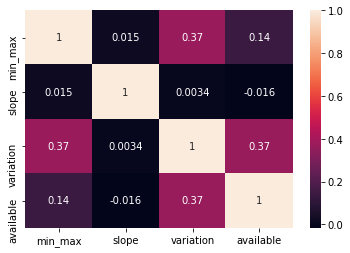

In [15]:
min_max.name = "min_max"
slope.name ="slope"
variation.name = "variation"
available.name = "available"



combined_metrics = pd.concat([min_max, slope, variation, available], axis=1)
corr_matrix = combined_metrics.corr()

sns.heatmap(corr_matrix, annot=True);